# Detection of an unknown pulsar and measurement of its period

In [2]:
# Preamble and imports
from __future__ import (print_function, absolute_import, division)

import os
import numpy as np
from  matplotlib import pyplot as plt
import matplotlib
from math import pi

%matplotlib inline

font = {'family' : 'serif',
        'weight' : 'normal',
        'size'   : 12}
matplotlib.rc('font', **font)

## 1. Importing Data

In [4]:
# Get the directory with the data
current_dir = os.getcwd()
root_dir = os.path.abspath(os.path.join(current_dir, os.pardir))
data_dir = os.path.join(root_dir, "DataSP", "FFT")

def get_header(file_name):
    """
    Function that reads in the header files.
    
    @param file_name :: name of the file
    
    @returns :: contents of header file as array
                of lines
    """
    
    file_name = file_name + '.hdr'
    data_file = os.path.join(data_dir, file_name)
    with open(data_file) as dfile:
        lines = dfile.readlines()
        for i, line in enumerate(lines):
            lines[i] = line.strip()
    
    return lines


def get_data(file_name):
    """
    Function that returns the data in the files.
    
    @param file_name :: name of the file
    
    @returns :: contents of the data file
                in one numpy array
    """
    
    file_name = file_name + '.dat'
    data_file = os.path.join(data_dir, file_name)
    with open(data_file) as dfile:
        data = np.fromfile(dfile)
    
    return data

## 2. Fourier Transform Demo

In [25]:
def generate_times(dt, npts):
    """
    Generate the times for the demo.
    
    @param dt :: interval between times
    @param npts :: number of time points
    
    @returns :: array of times
    """

    times = np.linspace(0,(npts-1)*dt,npts)
    
    return times

def generate_signal(times, period):
    """
    Generates the fake signal.
    
    @param times :: array of times
    @param period :: period of the signal
    
    @returns :: fake signal
    """
    
    fake_signal = np.sin(2*pi*times/period)
    
    return fake_signal
    
def generate_noise(npts):
    """
    Generates random noise.
    
    @param npts :: number of points
    
    @returns :: random distributed noise
    """
    
    random_noise = np.random.normal(0,20,npts)
    
    return random_noise

## 2.1 Plotting

In [19]:
def raw_plot(times, raw_bytes, fake_signal):
    """
    Plots the raw simulated data with the signal.
    
    @param times :: array of times
    @param raw_bytes :: array of data
    @param fake_signal :: fake signal data
    
    @returns :: plot of the signal with the data
    """
    
    plt.figure(figsize=(10,3))
    plt.plot(times, raw_bytes)
    plt.plot(times, fake_signal, color='red')
    plt.xlabel("Time (seconds)")
    plt.ylabel("Amplitude")
    plt.title("Simulated noise plus sinusoidal signal")


def signal_plot(times, raw_bytes, fake_signal):
    """
    Signal plot of the data (zoomed in)
    
    @param times :: array of times
    @param raw_bytes :: array of data
    @param fake_signal :: fake signal data
    
    @returns :: plot of the signal with data zoomed in
    """
    
    plt.figure(figsize=(10,3))
    plt.plot(times, raw_bytes)
    plt.plot(times, fake_signal, color='red', linewidth=2)
    plt.xlabel("Time (seconds)")
    plt.ylabel("Amplitude")
    plt.title("Zoomed to show signal amplitude")
    plt.xlim(0,5)
    plt.ylim(-3,3)

## 3. Fourier Transforms

In [12]:
def fourier_transform(raw_bytes):
    """
    Fourier transforms data.
    
    @param raw_bytes :: the data
    
    @returns :: the power of the fourier transformed
                data along with a plot
    """
    
    ft = np.fft.rfft(raw_bytes)
    power = np.real(ft)*np.real(ft) + np.imag(ft)*np.imag(ft)
    
    plot_transform(power)
    
    return power


def plot_transform(power):
    """
    Plot the power spectrum obtained through the
    fourier transform of the data.
    
    @param power :: power data
    
    @returns :: plot of the power spectrum
    """
    
    plt.figure(figsize=(10,10))
    plt.plot(power)
    plt.xlabel("Frequency (units?)")
    plt.ylabel("Power")
    plt.title("Power spectrum of simulated data")

## 4. Kowalsky, Analysis.

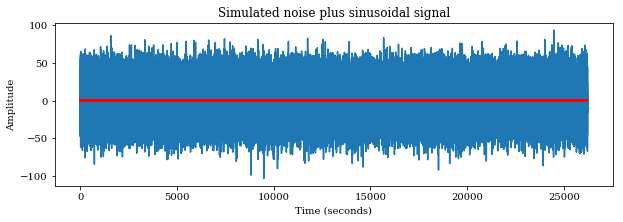

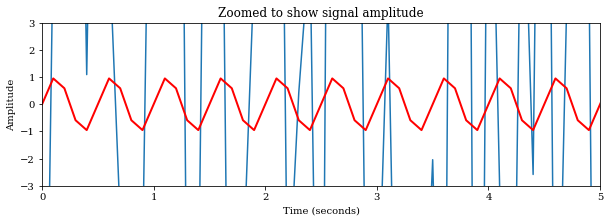

In [26]:
# Choose time interval and number of points
dt = 0.1
npts = 262144
period = 0.5

# Generate data
times = generate_times(dt, npts)
fake_signal = generate_signal(times, period)
noise = generate_noise(npts)
raw_bytes = noise + fake_signal

# Plot data
raw_plot(times, raw_bytes, fake_signal)
signal_plot(times, raw_bytes, fake_signal)

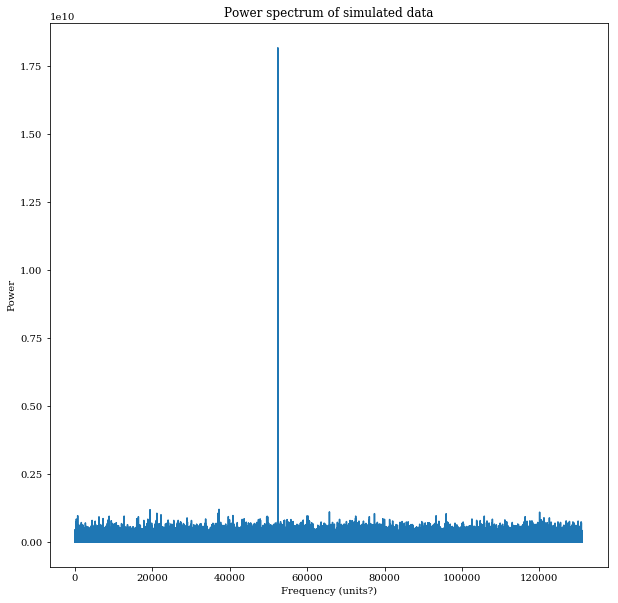

In [27]:
power = fourier_transform(raw_bytes)